# Fundamental Matrix Estimation, Camera Calibration, Triangulation (Python)
## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the Fundamental Matrix Estimation, Camera Calibration, Triangulation section of MP 3. We outline the required functionalities step by step. Feel free to make modifications on the starter code if it's necessary.

## Package installation
- You will need [GUI backend](https://matplotlib.org/faq/usage_faq.html#what-is-a-backend) to enable interactive plots in `matplotlib`.
- `numpy`
- `PIL`

#### Common imports

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
from math import sqrt

#### Part (1)

In [2]:
def get_residual(F, p1, p2):
    """
    Function to compute the residual average residual on frame 2
    param: F (3x3): fundamental matrix: (pt in frame 2).T * F * (pt in frame 1) = 0
    param: p1 (Nx2): 2d points on frame 1
    param: p2 (Nx2): 2d points on frame 2
    """
    P1 = np.c_[p1, np.ones((p1.shape[0],1))].transpose()
    P2 = np.c_[p2, np.ones((p2.shape[0],1))].transpose()
    L2 = np.matmul(F, P1).transpose()
    L2_norm = np.sqrt(L2[:,0]**2 + L2[:,1]**2)
    L2 = L2 / L2_norm[:,np.newaxis]
    pt_line_dist = np.multiply(L2, P2.T).sum(axis = 1)
    return np.mean(np.square(pt_line_dist))

def plot_fundamental(ax, F, p1, p2, I):
    """
    Function to display epipolar lines and corresponding points
    param: F (3x3): fundamental matrix: (pt in frame 2).T * F * (pt in frame 1) = 0
    param: p1 (Nx2): 2d points on frame 1
    param: p2 (Nx2): 2d points on frame 2
    param: I: frame 2
    """
    N = p1.shape[0]
    P1 = np.c_[p1, np.ones((N,1))].transpose()
    P2 = np.c_[p2, np.ones((N,1))].transpose()
    L2 = np.matmul(F, P1).transpose() # transform points from 

    # the first image to get epipolar lines in the second image
    L2_norm = np.sqrt(L2[:,0]**2 + L2[:,1]**2)
    L2 = L2 / L2_norm[:,np.newaxis]
    pt_line_dist = np.multiply(L2, P2.T).sum(axis=1)
    closest_pt = p2 - (L2[:,0:2]*pt_line_dist[:,np.newaxis])

    # Find endpoints of segment on epipolar line (for display purposes).
    # offset from the closest point is 10 pixels
    pt1 = closest_pt - np.c_[L2[:,1], -L2[:,0]]*10 
    pt2 = closest_pt + np.c_[L2[:,1], -L2[:,0]]*10

    # Display points and segments of corresponding epipolar lines.
    # You will see points in red corsses, epipolar lines in green 
    # and a short cyan line that denotes the shortest distance between
    # the epipolar line and the corresponding point.
    ax.set_aspect('equal')
    ax.imshow(np.array(I))
    ax.plot(p2[:,0],p2[:,1],  '+r')
    ax.plot([p2[:,0], closest_pt[:,0]],[p2[:,1], closest_pt[:,1]], 'r')
    ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')

In [3]:
# write your code here for part estimating essential matrices
def fit_fundamental(matches):
    """
    Solves for the fundamental matrix using the matches with unnormalized method.
    """
    # <YOUR CODE>
#     Estimate the fundamental matrix by the eight-point algorithm. 
# I will randomly use eight points from both p1 and p2. 
    p1 = matches[:, :2]
    p2 = matches[:, 2:]
    
    rand_idx = random.sample(range(p1.shape[0]), k=8)
    rand_p1 = p1[rand_idx]
    rand_p2 = p2[rand_idx]
    
    # Solve the homogeneous lineaar system using eight or more matches
    A = np.zeros((rand_p1.shape[0],9))
    for i in range(rand_p1.shape[0]):
        p1 = rand_p1[i]
        p2 = rand_p2[i]
        A[i] = [p2[0]*p1[0], p2[0]*p1[1], p2[0], p2[1]*p1[0], p2[1]*p1[1], p2[1], p1[0], p1[1], 1]

    # Enforce the rank-2 constraint by taking SVD of F 
    U, S, Vt = np.linalg.svd(A)
    F = Vt[len(Vt)-1].reshape(3, 3)
    F = F / F[2, 2] 

    #Set the smallest singular value to zero
    U, S, Vt = np.linalg.svd(F)
    s_diag = np.diag(S)

    s_diag[-1] = 0
    F = np.dot(U, np.dot(s_diag, Vt))

    return F


def fit_fundamental_normalized(matches):
    """
    Solve for the fundamental matrix using the matches with normalized method.
    """ 
    # <YOUR CODE> 
    #     Estimate the fundamental matrix by the eight-point algorithm. 
# I will randomly use eight points from both p1 and p2. 
    p1 = matches[:, :2]
    p2 = matches[:, 2:]
    
    #I will center the image data at the origin, 
    #and scale it so the mean squared distance between the origin and the data points is 2 pixels.
    p1, T1 = normalize(p1)
    p2, T2 = normalize(p2)
    
    # Solve the homogeneous lineaar system using eight or more matches
    rand_idx = random.sample(range(p1.shape[0]), k=8)
    rand_p1 = p1[rand_idx]
    rand_p2 = p2[rand_idx]

    A = np.zeros((rand_p1.shape[0],9))
    for i in range(rand_p1.shape[0]):
        p1 = rand_p1[i]
        p2 = rand_p2[i]
        A[i] = [p2[0]*p1[0], p2[0]*p1[1], p2[0], p2[1]*p1[0], p2[1]*p1[1], p2[1], p1[0], p1[1], 1]
    # Enforce the rank-2 constraint by taking SVD of F 
    U, S, Vt = np.linalg.svd(A)
    F = Vt[len(Vt)-1].reshape(3, 3)
    F = F / F[2, 2] 
    
    #Set the smallest singular value to zero
    U, S, Vt = np.linalg.svd(F)
    s_diag = np.diag(S)

    s_diag[-1] = 0
    #At the end, I transform fundamental matrix back to original units.
    F = np.dot(U, np.dot(s_diag, Vt))
    F = np.dot(np.dot(T2.T, F), T1)

    return F

def normalize(pts):
    
    # scale it so the mean squared distance between the origin and the data points is 2 pixels.
    pts_centered = pts - np.mean(pts,axis= 0)

    scale = 1/ (sqrt(1 / (2 * len(pts)) * np.sum(pts_centered[:, 0]**2 + pts_centered[:, 1]**2)))
    
    #Calculate the transform results
    transform = np.array([[scale, 0, -scale*np.mean(pts,axis= 0)[0]], 
                           [0, scale, -scale*np.mean(pts,axis= 0)[1]], 
                           [0, 0, 1]])
    pts = np.concatenate((pts, np.ones((pts.shape[0], 1))), axis=1)
    normalized = np.dot(transform, pts.T).T
    
    return normalized[:, :2], transform


library: fundamental matrix (non-normalized method) =  [[-8.26620690e-06  1.24083876e-04 -1.44516393e-02]
 [-8.44116163e-05  1.34481579e-05 -9.28757521e-03]
 [ 1.07866358e-02 -2.48295672e-05  1.00000000e+00]]
library: residual in frame 2 (non-normalized method) =  5.757786850785962
library: residual in frame 1 (non-normalized method) =  5.660999428234666
library: residual combined   (non-normalized method) =  5.709393139510314
library: fundamental matrix (normalized method) =  [[-3.08049853e-05 -1.60507197e-04  9.60117951e-02]
 [-1.25335594e-05  3.56732456e-05  2.24509797e-01]
 [-2.82656518e-02 -2.00745398e-01 -1.00982439e+01]]
library: residual in frame 2 (normalized method) =  4.714370080189856
library: residual in frame 1 (normalized method) =  4.547690567591421
library: residual combined   (normalized method) =  4.631030323890639


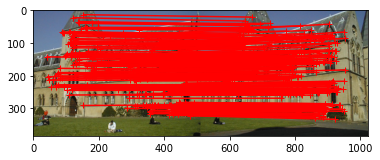

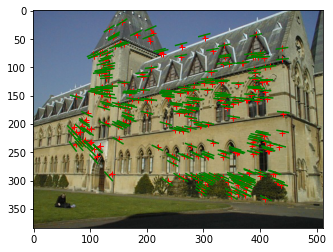

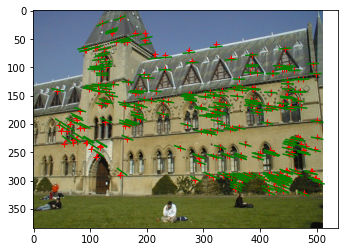

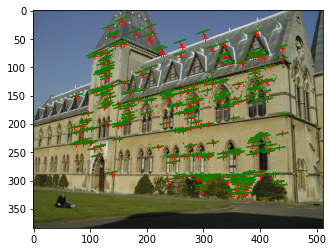

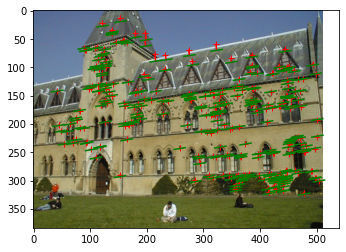

In [5]:
# Fundamental matrix estimation
name = 'library' 
# You also need to report results for name = 'lab'
# name = 'lab'

I1 = Image.open('./{:s}1.jpg'.format(name))
I2 = Image.open('./{:s}2.jpg'.format(name))
matches = np.loadtxt('./{:s}_matches.txt'.format(name))
N = len(matches);

## Display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
I3 = np.zeros((I1.size[1],I1.size[0]*2,3))
I3[:,:I1.size[0],:] = I1;
I3[:,I1.size[0]:,:] = I2;
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
ax.imshow(np.array(I3).astype(np.uint8))

# non-normalized method
F = fit_fundamental(matches) # <YOUR CODE>
print('{:s}: fundamental matrix (non-normalized method) = '.format(name), F)

pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]
v2 = get_residual(F, pt1_2d, pt2_2d)
v1 = get_residual(F.T, pt2_2d, pt1_2d)
print('{:s}: residual in frame 2 (non-normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (non-normalized method) = '.format(name), v1)
print('{:s}: residual combined   (non-normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)

# normalized method
F = fit_fundamental_normalized(matches) # <YOUR CODE>
print('{:s}: fundamental matrix (normalized method) = '.format(name), F)

pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]
v2 = get_residual(F, pt1_2d, pt2_2d)
v1 = get_residual(F.T, pt2_2d, pt1_2d)
print('{:s}: residual in frame 2 (normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (normalized method) = '.format(name), v1)
print('{:s}: residual combined   (normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)

lab: fundamental matrix (non-normalized method) =  [[-8.15830597e-07  1.17455670e-05 -2.79952994e-03]
 [ 8.48824653e-06  3.87723030e-07  2.32726514e-02]
 [-2.23868412e-04 -3.38011347e-02  1.00000000e+00]]
lab: residual in frame 2 (non-normalized method) =  23.868587587556185
lab: residual in frame 1 (non-normalized method) =  35.090045100440335
lab: residual combined   (non-normalized method) =  29.47931634399826
lab: fundamental matrix (normalized method) =  [[ 6.51737363e-06 -9.43945314e-05  2.37118310e-02]
 [-7.80849993e-05  2.21088974e-06 -1.91463451e-01]
 [ 5.46117380e-03  2.79071654e-01 -9.52387954e+00]]
lab: residual in frame 2 (normalized method) =  1.6141862088440562
lab: residual in frame 1 (normalized method) =  1.3500316997679676
lab: residual combined   (normalized method) =  1.4821089543060117


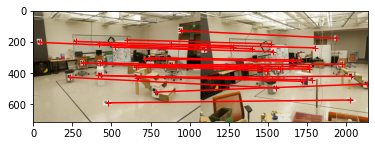

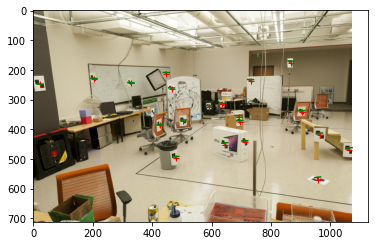

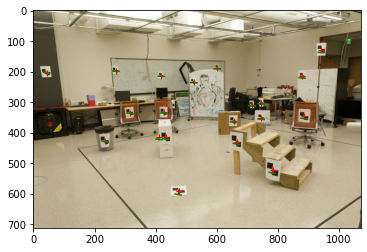

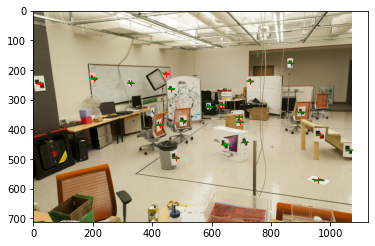

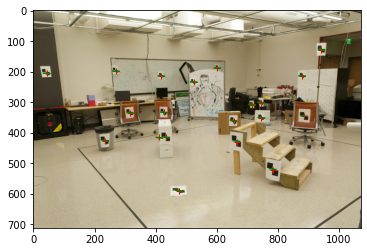

In [6]:
# Fundamental matrix estimation
# name = 'library' 
# You also need to report results for name = 'lab'
name = 'lab'

I1 = Image.open('./{:s}1.jpg'.format(name))
I2 = Image.open('./{:s}2.jpg'.format(name))
matches = np.loadtxt('./{:s}_matches.txt'.format(name))
N = len(matches);

## Display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
I3 = np.zeros((I1.size[1],I1.size[0]*2,3))
I3[:,:I1.size[0],:] = I1;
I3[:,I1.size[0]:,:] = I2;
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
ax.imshow(np.array(I3).astype(np.uint8))

# non-normalized method
F = fit_fundamental(matches) # <YOUR CODE>
print('{:s}: fundamental matrix (non-normalized method) = '.format(name), F)

pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]
v2 = get_residual(F, pt1_2d, pt2_2d)
v1 = get_residual(F.T, pt2_2d, pt1_2d)
print('{:s}: residual in frame 2 (non-normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (non-normalized method) = '.format(name), v1)
print('{:s}: residual combined   (non-normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)

# normalized method
F = fit_fundamental_normalized(matches) # <YOUR CODE>
print('{:s}: fundamental matrix (normalized method) = '.format(name), F)

pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]
v2 = get_residual(F, pt1_2d, pt2_2d)
v1 = get_residual(F.T, pt2_2d, pt1_2d)
print('{:s}: residual in frame 2 (normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (normalized method) = '.format(name), v1)
print('{:s}: residual combined   (normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)

#### Part (2)

In [7]:
def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

# Write your code here for camera calibration (lab)
def camera_calibration(pts_3d, matches):
    """
    write your code to compute camera matrix
    """
    # <YOUR CODE>
    #calculate the projection matrix
    N = len(pts_3d)
#     print(pts_3d)
    pts_3d = np.hstack((pts_3d, np.ones((N, 1))))
#     print(pts_3d)


    #get A
    A = []
    for i in range(N):
        
        a,b,c,d = pts_3d[i]
        x,y = matches[i]
        r1 = np.array([0, 0, 0, 0, a, b, c, d, -y*a, -y*b, -y*c, -y*d])
        r2 = np.array([a, b, c, d, 0, 0, 0, 0, -x*a, -x*b, -x*c, -x*d])
        A.append(r1)
        A.append(r2)
    
    A = np.array(A)
    
    #find SVD of the A
    
    U,S,VT = np.linalg.svd(A)
    p = VT[-1,:].reshape((3,4))
    p /= p[2,2]
    
    return p

# Load 3D points, and their corresponding locations in 
# the two images.
pts_3d = np.loadtxt('./lab_3d.txt')
matches = np.loadtxt('./lab_matches.txt')

# <YOUR CODE> print lab camera projection matrices:
lab1_proj = camera_calibration(pts_3d, matches[:,:2])
lab2_proj = camera_calibration(pts_3d, matches[:,:2])
print('lab 1 camera projection')
print(lab1_proj)

print('')
print('lab 2 camera projection')
print(lab2_proj)

# <YOUR CODE> evaluate the residuals for both estimated cameras
_, lab1_res = evaluate_points(lab1_proj, matches[:,:2], pts_3d)
print('residuals between the observed 2D points and the projected 3D points:')
print('residual in lab1:', lab1_res)
_, lab2_res = evaluate_points(lab1_proj, matches[:,:2], pts_3d)
print('residual in lab2:', lab2_res)

lab 1 camera projection
[[-4.53187041e+03 -2.13760331e+02  6.55731767e+02  1.43125880e+06]
 [-4.48880175e+02 -9.31617589e+02  4.05512340e+03  2.98472081e+05]
 [-2.45529487e+00 -4.01727797e+00  1.00000000e+00  1.94283277e+03]]

lab 2 camera projection
[[-4.53187041e+03 -2.13760331e+02  6.55731767e+02  1.43125880e+06]
 [-4.48880175e+02 -9.31617589e+02  4.05512340e+03  2.98472081e+05]
 [-2.45529487e+00 -4.01727797e+00  1.00000000e+00  1.94283277e+03]]
residuals between the observed 2D points and the projected 3D points:
residual in lab1: 13.545832895478238
residual in lab2: 13.545832895478238


In [9]:
lib1_proj = np.loadtxt('./library1_camera.txt')
lib2_proj = np.loadtxt('./library2_camera.txt')
print('library1 camera projection')
print(lib1_proj)
print('library2 camera projection')
print(lib2_proj)

# <YOUR CODE> evaluate the residuals for both estimated cameras
_, lib1_res = evaluate_points(lib1_proj, matches[:,:2], pts_3d)
print('residuals between the observed 2D points and the projected 3D points:')
print('residual in lib1:', lib1_res)
_, lib2_res = evaluate_points(lib2_proj, matches[:,:2], pts_3d)
print('residual in lib2:', lib2_res)

library1 camera projection
[[-4.5250208e+01  4.8215478e+02  4.0948922e+02  3.4440464e+03]
 [ 4.8858466e+02  2.7346374e+02 -1.3977268e+02  4.8030231e+03]
 [-1.9787463e-01  8.8042214e-01 -4.3093212e-01  2.8032556e+01]]
library2 camera projection
[[-5.9593834e+01  5.5643970e+02  2.3093716e+02  3.5683545e+03]
 [ 4.6419679e+02  2.2628430e+02 -1.9605278e+02  4.8734171e+03]
 [-1.9116708e-01  7.2057697e-01 -6.6650130e-01  2.8015392e+01]]
residuals between the observed 2D points and the projected 3D points:
residual in lib1: 15206.598973282029
residual in lib2: 20303.11980049929


#### Part (3)

In [11]:
# Write your code here for computing camera centers
def calc_camera_center(M):
    """
    write your code to get camera center in the world 
    from the projection matrix
    """
    #Find out the SDV of the projection matrix got the VT.
    U,S,VT = np.linalg.svd(M)
    
    #he center would be the last row of VT normalized. 
    center = VT[-1,:] 
    center /= center[-1]
    return center

# <YOUR CODE> compute the camera centers using 
# the projection matrices
lab1_c = calc_camera_center(lab1_proj)
lab2_c = calc_camera_center(lab2_proj)
print('lab1 camera center', lab1_c)
print('lab2 camera center', lab2_c)

# <YOUR CODE> compute the camera centers with the projection matrices
lib1_c = calc_camera_center(lib1_proj)
lib2_c = calc_camera_center(lib2_proj)
print('library1 camera center', lib1_c)
print('library2 camera center', lib2_c)


lab1 camera center [305.83276769 304.20103826  30.13699243   1.        ]
lab2 camera center [305.83276769 304.20103826  30.13699243   1.        ]
library1 camera center [  7.28863053 -21.52118112  17.73503585   1.        ]
library2 camera center [  6.89405488 -15.39232716  23.41498687   1.        ]


#### Part (4)

Mean 3D reconstuction error for the lab data:  130.65347
2D reprojection error for the lab 1 data:  180592.3864511776
2D reprojection error for the lab 2 data:  179810.2917705987
2D reprojection error for the library 1 data:  51.53227122145688
2D reprojection error for the library 2 data:  81.28132134975516


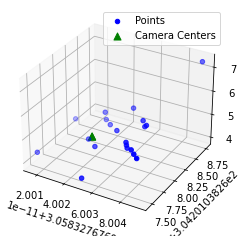

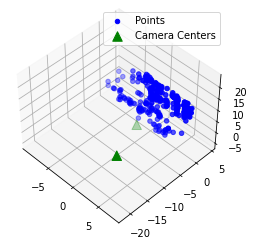

In [12]:
# Write your code here for triangulation
from mpl_toolkits.mplot3d import Axes3D
def triangulation(match, p1, p2):
    """
    write your code to triangulate the points in 3D
    """
    # <YOUR CODE>
    # We use the linear approach and to solve the cross product as the metrix multiplication
    #Refer Lecture 14 Slides 37
    res = []
    for i in range(len(match)):
        x1, y1 = match[i,:2]
        x2, y2 = match[i,2:]
        r1 = np.array([[0, -1, y1],[1, 0, -x1],[-y1, x1, 0]])
        r2 = np.array([[0, -1, y2],[1, 0, -x2],[-y2, x2, 0]])
        r1 = np.dot(r1, p1)
        r2 = np.dot(r2, p2)
        A = np.vstack((r1,r2))
        u,s,v = np.linalg.svd(A)
        p = v[-1,:]
        p /= p[-1]
        res.append(p[:3])
    res = np.array(res)
    return res 

def evaluate_points_3d(est, gt):
    """
    write your code to evaluate the triangulated 3D points
    """
    # <YOUR CODE>
    return np.sum(np.hypot(gt[:,0]-est[:, 0], gt[:,1]-est[:, 1], gt[:,2]-est[:,2]))

# triangulate the 3D point cloud for the lab data 
matches_lab = np.loadtxt('./lab_matches.txt')
points_3d_gt = np.loadtxt('./lab_3d.txt')
lab_pt1 = matches_lab[:,:2]# <YOUR CODE>
lab_pt2 = matches_lab[:,2:]# <YOUR CODE>
points_3d_lab = triangulation(matches_lab, lab1_proj, lab2_proj) # <YOUR CODE>
res_3d_lab = evaluate_points_3d(points_3d_lab, points_3d_gt) # <YOUR CODE>
print('Mean 3D reconstuction error for the lab data: ', round(np.mean(res_3d_lab), 5))
_, res_2d_lab1 = evaluate_points(lab1_proj, lab_pt1, points_3d_lab)
_, res_2d_lab2 = evaluate_points(lab2_proj, lab_pt2, points_3d_lab)
print('2D reprojection error for the lab 1 data: ', np.mean(res_2d_lab1))
print('2D reprojection error for the lab 2 data: ', np.mean(res_2d_lab2))
# visualization of lab point cloud
camera_centers = np.vstack((lab1_c, lab2_c))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d_lab[:, 0], points_3d_lab[:, 1], points_3d_lab[:, 2], c='b', label='Points')
ax.scatter(camera_centers[:, 0], camera_centers[:, 1], camera_centers[:, 2], c='g', s=50, marker='^', label='Camera Centers')
ax.legend(loc='best')

# triangulate the 3D point cloud for the library data
matches_lib = np.loadtxt('./library_matches.txt')
lib_pt1 = matches_lib[:,:2]# <YOUR CODE>
lib_pt2 = matches_lib[:,2:]# <YOUR CODE>
points_3d_lib = triangulation(matches_lib,lib1_proj, lib2_proj ) # <YOUR CODE>
_, res_2d_lib1 = evaluate_points(lib1_proj, lib_pt1, points_3d_lib)
_, res_2d_lib2 = evaluate_points(lib2_proj, lib_pt2, points_3d_lib)
print('2D reprojection error for the library 1 data: ', np.mean(res_2d_lib1))
print('2D reprojection error for the library 2 data: ', np.mean(res_2d_lib2))
# visualization of library point cloud
camera_centers_library = np.vstack((lib1_c, lib2_c))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d_lib[:, 0], points_3d_lib[:, 1], points_3d_lib[:, 2], c='b', label='Points')
ax.scatter(camera_centers_library[:, 0], camera_centers_library[:, 1], 
           camera_centers_library[:, 2], c='g', s=90, 
           marker='^', label='Camera Centers')
ax.view_init(azim=-45, elev=45)
ax.legend(loc='best')

Part (extra credit)


In [29]:
#This block I paste some code for what I did in Q1
import numpy as np
import skimage
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy
import skimage.io
import random
import skimage.transform
from PIL import Image

def imread(fname):
    """
    read image into np array from file
    """
    return skimage.io.imread(fname)

def imread_bw(fname):
    """
    read image as gray scale format
    """
    return cv2.cvtColor(imread(fname), cv2.COLOR_BGR2GRAY)


def imshow(img):
    """
    show image
    """
    skimage.io.imshow(img)
    
def get_sift_data(img):
    """
    detect the keypoints and compute their SIFT descriptors with opencv library
    """
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    plot the match between two image according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """

    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')
    
def get_best_matches(img1, img2, num_matches):
    kp1, des1 = get_sift_data(img1)
    kp2, des2 = get_sift_data(img2)
    kp1, kp2 = np.array(kp1), np.array(kp2)
    
    # Find distance between descriptors in images
    dist = scipy.spatial.distance.cdist(des1, des2, 'sqeuclidean')
    
    # Write your code to get the matches according to dist
    # <YOUR CODE>

    idx1 = np.where(dist < num_matches)[0]
    idx2 = np.where(dist < num_matches)[1]
    c1 = []
    c2 = []
    for idx in idx1:
        c1.append(kp1[idx].pt)
    c1 = np.array(c1)
    
    for idx in idx2:
        c2.append(kp2[idx].pt)
    c2 = np.array(c2)

    # put into pairs of coords
    if len(c1) == 0 and len(c2) == 0:
        print("num_matches is too small")
        return []
    
    best_matches = np.concatenate((c1, c2), axis=1)

    return best_matches

def ransac(img1, img2, matches, thres_ransac):
    """
    write your ransac code to find the best model, inliers, and residuals
    """
    # <YOUR CODE>
    num_iterations = 10000
    inliners = 0
    max_inliers = 0

    for i in range(num_iterations):
        subset = matches[random.sample(range(matches.shape[0]), k=4)]
        H = compute_homography(subset)
        if np.linalg.matrix_rank(H) < 3:
            continue

        errors = get_errors(matches, H)
        idx = np.where(errors < thres_ransac)[0]
        inlinerspts = matches[idx]

        inliners = len(inlinerspts)
        if inliners >= max_inliers:
            which_inliners = inlinerspts.copy()
            max_inliers = inliners
            best_H = H.copy()
            avg_residual = sum(get_errors(matches[idx], H)) / inliners

    return best_H, which_inliners, avg_residual, max_inliers


def get_errors(matches, H):

    n = len(matches)

    p1 = np.concatenate((matches[:, 0:2], np.ones((1, n)).T), axis=1)
    p2 = matches[:, 2:4]

    transformed = np.zeros((n, 2))
    for i in range(n):
        transformed[i] = (np.dot(H, p1[i]) / np.dot(H, p1[i])[-1])[:2]

    errors = np.linalg.norm(p2 - transformed, axis=1) ** 2
    return errors

def compute_homography(subset):
    """
    write your code to compute homography according to the matches
    """
    PH = []

    for i in range(subset.shape[0]):
        p1 = np.append(subset[i][:2], 1)
        p2 = np.append(subset[i][2:], 1)
        
        row1 = [0, 0, 0, p1[0], p1[1], p1[2], -p2[1]*p1[0], -p2[1]*p1[1], -p2[1]*p1[2]]
        row2 = [p1[0], p1[1], p1[2], 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1], -p2[0]*p1[2]]
        PH.append(row1)
        PH.append(row2)

    PH = np.array(PH)

    U, S, Vt = np.linalg.svd(PH)
    H = Vt[len(Vt)-1].reshape(3, 3)

    # normalize
    H = H / H[2, 2]
    return H


Average residual: 0.06766314513759808
Inliers: 16


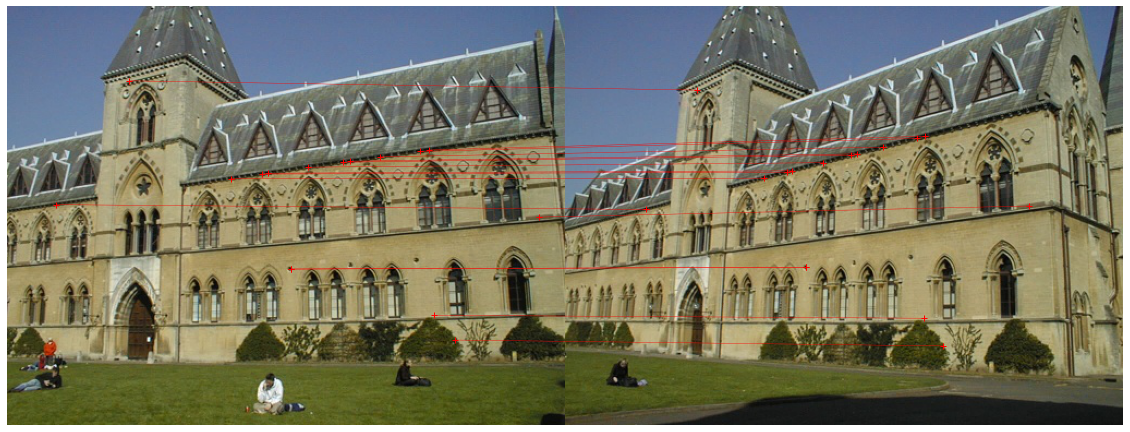

In [30]:

name = 'library' 
img1 = imread('./{:s}1.jpg'.format(name))
img2 = imread('./{:s}2.jpg'.format(name))
matches = get_best_matches(img1, img2, 10000)
best_H,data, avg_residual, max_inliers = ransac(img1, img2, matches, 0.3)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, data)

print("Average residual:", avg_residual)
print("Inliers:", max_inliers)
fig.savefig('ransac_match.pdf', bbox_inches='tight')

Average residual: 0.07207980171915132
Inliers: 27


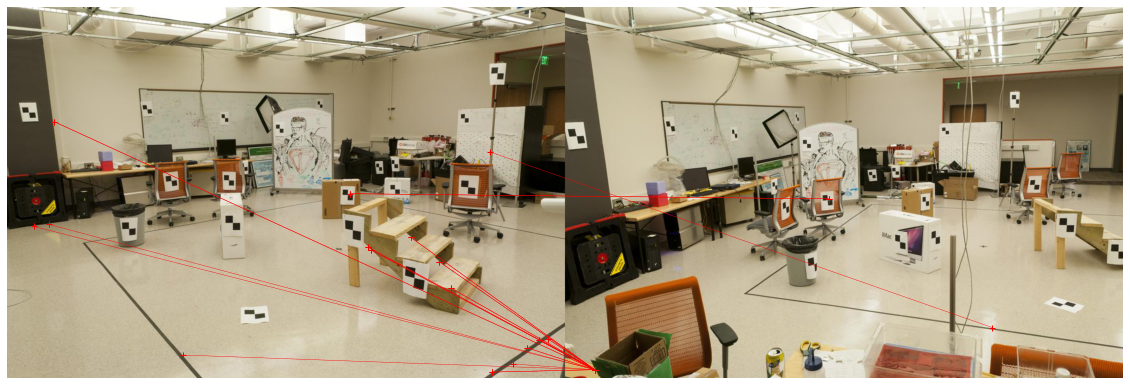

In [31]:

name = 'lab' 
img1 = imread('./{:s}1.jpg'.format(name))
img2 = imread('./{:s}2.jpg'.format(name))
matches = get_best_matches(img1, img2, 10000)
best_H,data, avg_residual, max_inliers = ransac(img1, img2, matches, 0.3)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, data)

print("Average residual:", avg_residual)
print("Inliers:", max_inliers)
fig.savefig('ransac_match.pdf', bbox_inches='tight')